<a href="https://colab.research.google.com/github/RishitSaxena55/WhisprNet/blob/main/WhisprNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WhisprNet : An Encoder-Decoder Transformer based ASR System**

## First Clone the repo from github
-> https://github.com/RishitSaxena55/WhisprNet

In [ ]:
!git clone https://github.com/RishitSaxena55/WhisprNet.git

In [ ]:
# To pull latest changes (Must be in the repo dir, use pwd/ls to verify)
!cd WhisprNet && git pull

## Add a dataset : I have used ASR Dataset hosted by CMU

In [ ]:
!curl -L -o /content/s25-hw4-data.zip https://www.kaggle.com/api/v1/datasets/download/cmu11785/s25-hw4-data
!unzip -q -o /content/s25-hw4-data.zip -d /content/hw4_data
!rm -rf /content/s25-hw4-data.zip
!du -h --max-depth=2 /content/hw4_data

## Move to repo directory

In [ ]:
import os
os.chdir('WhisprNet')
!ls

## Install requirements

In [ ]:
!pip install -r requirements.txt

## Imports

In [ ]:
!pip install -q transformers -U

from WhiprNet_lib.data import (
    H4Tokenizer,
    ASRDataset,
    verify_dataloader
)
from WhiprNet_lib.model import (
    DecoderOnlyTransformer,
    EncoderDecoderTransformer
)
from WhiprNet_lib.utils import (
    create_scheduler,
    create_optimizer,
    plot_lr_schedule
)
from WhiprNet_lib.trainers import (
    ASRTrainer,
    ProgressiveTrainer
)
from torch.utils.data import DataLoader
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import wandb
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

## Load Config File (You can also modify hyperparameters if you want to experiment)

In [ ]:
%%writefile config.yaml

Name                      : "WhisprNet"

###### Tokenization ------------------------------------------------------------
tokenization:
  token_type                : "5k"       # [char, 1k, 5k, 10k]
  token_map :
      'char': 'WhisprNet_lib/data/tokenizer_jsons/tokenizer_char.json'
      '1k'  : 'WhisprNet_lib/data/tokenizer_jsons/tokenizer_1000.json'
      '5k'  : 'WhisprNet_lib/data/tokenizer_jsons/tokenizer_5000.json'
      '10k' : 'WhisprNet_lib/data/tokenizer_jsons/tokenizer_10000.json'

###### Dataset -----------------------------------------------------------------
data:
  root                 : "/kaggle/input/s25-hw4-data/hw4p2_data"  # Set the root path of your data
  train_partition      : "train-clean-100"  # paired text-speech for ASR pre-training
  val_partition        : "dev-clean"        # paired text-speech for ASR pre-training
  test_partition       : "test-clean"       # paired text-speech for ASR pre-training
  subset               : 1.0                # Load a subset of the data (for debugging, testing, etc
  batch_size           : 8          #
  NUM_WORKERS          : 2            # Set to 0 for CPU
  norm                 : 'global_mvn' # ['global_mvn', 'cepstral', 'none']
  num_feats            : 80

  ###### SpecAugment ---------------------------------------------------------------
  specaug                   : True  # Set to True if you want to use SpecAugment
  specaug_conf:
    apply_freq_mask         : True
    freq_mask_width_range   : 5
    num_freq_mask           : 2
    apply_time_mask         : True
    time_mask_width_range   : 40
    num_time_mask           : 2

###### Network Specs -------------------------------------------------------------
model: # Encoder-Decoder Transformer (HW4P2)
  # Speech embedding parameters
  input_dim: 80              # Speech feature dimension
  time_reduction: 2          # Time dimension downsampling factor
  reduction_method: 'conv'   # The source_embedding reduction method ['lstm', 'conv', 'both']

  # Architecture parameters
  d_model: 344          # Model dimension
  num_encoder_layers: 4  # Number of encoder layers
  num_decoder_layers: 4  # Number of decoder layers
  num_encoder_heads: 8  # Number of encoder attention heads
  num_decoder_heads: 8  # Number of decoder attention heads
  d_ff_encoder: 1536    # Feed-forward dimension for encoder
  d_ff_decoder: 1536     # Feed-forward dimension for decoder
  skip_encoder_pe: False # Whether to skip positional encoding for encoder
  skip_decoder_pe: False # Whether to skip positional encoding for decoder

  # Common parameters
  dropout: 0.1          # Dropout rate
  layer_drop_rate: 0.0  # Layer dropout rate
  weight_tying: False   # Whether to use weight tying

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "o99atvom" # "none" or "run_id"
  resume                      : True   # Resume an existing run (run_id != 'none')
  gradient_accumulation_steps : 1
  wandb_project               : "HW4P2" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' CrossEntropy
  label_smoothing: 0.1
  ctc_weight: 0.2

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 0.0004    # Base learning rate

  # Common parameters
  weight_decay: 0.000001

  # Parameter groups
  # You can add more param groups as you want and set their learning rates and patterns
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing "ffn" and set their learning rate to 0.0002
      lr: 0.0002    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0002
      lr: 0.0002   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 10    # Number of iterations for the first restart
    T_mult: 10 # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0


In [ ]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Tokenizer

In [ ]:
Tokenizer = H4Tokenizer(
    token_map  = config['tokenization']['token_map'],
    token_type = config['tokenization']['token_type']
)

                          Tokenizer Configuration (5k)                          
--------------------------------------------------------------------------------
Vocabulary size:     5000

Special Tokens:
PAD:              0
UNK:              1
MASK:             2
SOS:              3
EOS:              4
BLANK:            5

Validation Example:
--------------------------------------------------------------------------------
Input text:  [SOS]HI DEEP LEARNERS[EOS]
Tokens:      ['[SOS]', 'H', 'I', 'ĠDEEP', 'ĠLEARN', 'ERS', '[EOS]']
Token IDs:   [3, 14, 15, 1169, 2545, 214, 4]
Decoded:     [SOS]HI DEEP LEARNERS[EOS]


## Datasets

In [ ]:
train_dataset = ASRDataset(
    partition=config['data']['train_partition'],
    config=config['data'],
    tokenizer=Tokenizer,
    isTrainPartition=True,
    global_stats=None  # Will compute stats from training data
)

# Get the computed global stats from training set
global_stats = None
if config['data']['norm'] == 'global_mvn':
    global_stats = (train_dataset.global_mean, train_dataset.global_std)
    print(f"Global stats computed from training set.")

val_dataset = ASRDataset(
    partition=config['data']['val_partition'],
    config=config['data'],
    tokenizer=Tokenizer,
    isTrainPartition=False,
    global_stats=global_stats
)

test_dataset = ASRDataset(
    partition=config['data']['test_partition'],
    config=config['data'],
    tokenizer=Tokenizer,
    isTrainPartition=False,
    global_stats=global_stats
)

gc.collect()

Loading data for train-clean-100 partition...


100%|██████████| 28539/28539 [11:22<00:00, 41.82it/s]


Global stats computed from training set.
Loading data for dev-clean partition...


100%|██████████| 2703/2703 [00:51<00:00, 52.70it/s]


Loading data for test-clean partition...


100%|██████████| 2620/2620 [00:29<00:00, 90.08it/s] 


1063

## Dataloaders

In [ ]:
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = True,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn
)

test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

gc.collect()

0

### Dataloader Verification

In [ ]:
verify_dataloader(train_loader)

             Dataloader Verification              
Dataloader Partition     : train-clean-100
--------------------------------------------------
Number of Batches        : 3568
Batch Size               : 8
--------------------------------------------------
Checking shapes of the data...                    

Feature Shape            : [8, 2034, 80]
Shifted Transcript Shape : [8, 68]
Golden Transcript Shape  : [8, 68]
Feature Lengths Shape    : [8]
Transcript Lengths Shape : [8]
--------------------------------------------------
Max Feature Length       : 3066
Max Transcript Length    : 100
Avg. Chars per Token     : 4.24


In [ ]:
verify_dataloader(val_loader)

             Dataloader Verification              
Dataloader Partition     : dev-clean
--------------------------------------------------
Number of Batches        : 338
Batch Size               : 8
--------------------------------------------------
Checking shapes of the data...                    

Feature Shape            : [8, 3676, 80]
Shifted Transcript Shape : [8, 104]
Golden Transcript Shape  : [8, 104]
Feature Lengths Shape    : [8]
Transcript Lengths Shape : [8]
--------------------------------------------------
Max Feature Length       : 4081
Max Transcript Length    : 138
Avg. Chars per Token     : 4.17


In [ ]:
verify_dataloader(test_loader)

             Dataloader Verification              
Dataloader Partition     : test-clean
--------------------------------------------------
Number of Batches        : 328
Batch Size               : 8
--------------------------------------------------
Checking shapes of the data...                    

Feature Shape            : [8, 1320, 80]
Feature Lengths Shape    : [8]
--------------------------------------------------
Max Feature Length       : 4370
Max Transcript Length    : 0
Avg. Chars per Token     : 0.00


## Calculate Max Lengths


In [ ]:
max_feat_len       = max(train_dataset.feat_max_len, val_dataset.feat_max_len, test_dataset.feat_max_len)
max_transcript_len = max(train_dataset.text_max_len, val_dataset.text_max_len, test_dataset.text_max_len)
max_len            = max(max_feat_len, max_transcript_len)

print("="*50)
print(f"{'Max Feature Length':<30} : {max_feat_len}")
print(f"{'Max Transcript Length':<30} : {max_transcript_len}")
print(f"{'Overall Max Length':<30} : {max_len}")
print("="*50)

Max Feature Length             : 4370
Max Transcript Length          : 138
Overall Max Length             : 4370


## Wandb

In [ ]:
wandb.login(key="39e9c89279f6d046c7bae725e099c70ddf0fd98f")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rishitsaxena55 (rishitsaxena55-indian-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Training
Every time you run the trainer, it will create a new directory in the `expts` folder with the following structure:
```
expts/
    └── {run_name}/
        ├── config.yaml
        ├── model_arch.txt
        ├── checkpoints/
        │   ├── checkpoint-best-metric-model.pth
        │   └── checkpoint-last-epoch-model.pth
        ├── attn/
        │   └── {attention visualizations}
        └── text/
            └── {generated text outputs}
```


### Training Strategy : Cold-Start Trainer

#### Model Load (Default)

In [ ]:
model_config = config['model'].copy()
model_config.update({
    'max_len': max_len,
    'num_classes': Tokenizer.vocab_size
})

model = EncoderDecoderTransformer(**model_config)

# Get some inputs from the train dataloader
for batch in train_loader:
    padded_feats, padded_shifted, padded_golden, feat_lengths, transcript_lengths = batch
    break


model_stats = summary(model, input_data=[padded_feats, padded_shifted, feat_lengths, transcript_lengths])
print(model_stats)

Layer (type:depth-idx)                        Output Shape              Param #
EncoderDecoderTransformer                     [8, 72, 5000]             --
├─SpeechEmbedding: 1-1                        [8, 1079, 344]            --
│    └─Conv2DSubsampling: 2-1                 [8, 1079, 344]            --
│    │    └─Sequential: 3-1                   [8, 344, 1079, 76]        1,068,808
│    │    └─Linear: 3-2                       [8, 1079, 344]            8,993,880
│    │    └─Dropout: 3-3                      [8, 1079, 344]            --
├─PositionalEncoding: 1-2                     [8, 1079, 344]            --
├─Dropout: 1-3                                [8, 1079, 344]            --
├─ModuleList: 1-4                             --                        --
│    └─SelfAttentionEncoderLayer: 2-2         [8, 1079, 344]            --
│    │    └─SelfAttentionLayer: 3-4           [8, 1079, 344]            475,408
│    │    └─FeedForwardLayer: 3-5             [8, 1079, 344]            1,05

#### Initialize Trainer

If you need to reload the model from a checkpoint, you can do so by calling the `load_checkpoint` method.

```python
checkpoint_path = "path/to/checkpoint.pth"
trainer.load_checkpoint(checkpoint_path)
```


In [ ]:
trainer = ASRTrainer(
    model=model,
    tokenizer=Tokenizer,
    config=config,
    run_name="run-1",
    config_file="config.yaml",
    device=device
)

Using device: cuda


learning_rate,█▄▂▁
train/ce_loss,█▄▂▁
train/ctc_loss,█▄▂▁
train/joint_loss,█▄▂▁
train/perplexity_char,█▄▂▁
train/perplexity_token,█▄▂▁
val/cer,▅▁██
val/wer,▆▁██
val/word_dist,▅▁██
learning_rate,0.0
train/ce_loss,1.44911


### Setup Optimizer and Scheduler

You can set your own optimizer and scheduler by setting the class members in the `LMTrainer` class.
Eg:
```python
trainer.optimizer = optim.AdamW(model.parameters(), lr=config['optimizer']['lr'], weight_decay=config['optimizer']['weight_decay'])
trainer.scheduler = optim.lr_scheduler.CosineAnnealingLR(trainer.optimizer, T_max=config['training']['epochs'])
```



#### Setting up the optimizer

In [ ]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)


🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0004
├── Weight Decay: 1e-06
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0002
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0002
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


#### Creating a test scheduler and plotting the learning rate schedule


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (53520 steps)
│   └── Min LR: 1e-07
├── Warmup Settings:
│   ├── Duration: 5 epochs (17840 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


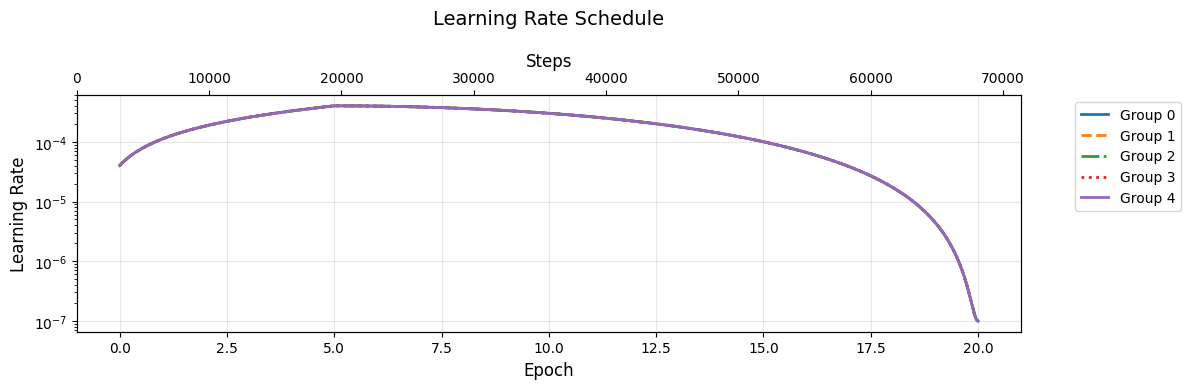

In [ ]:
test_scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=test_scheduler,
    num_epochs=20,
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

#### Setting up the scheduler

In [ ]:
trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (53520 steps)
│   └── Min LR: 1e-07
├── Warmup Settings:
│   ├── Duration: 5 epochs (17840 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


#### Train
- Set your epochs

In [ ]:
checkpoint_path = "/kaggle/input/best-model/pytorch/best-till-19-epochs/1/checkpoint-best-metric-model.pth"
trainer.load_checkpoint(checkpoint_path)

Checkpoint loaded from epoch 16
Successfully loaded: model, optimizer, scheduler, scaler, training_state


In [ ]:
trainer.train(train_loader, val_loader, epochs=4)


📊 Metrics (Epoch 15):
├── TRAIN:
│   ├── ce_loss: 1.4842
│   ├── ctc_loss: 1.1896
│   ├── joint_loss: 1.7222
│   ├── perplexity_char: 1.4194
│   └── perplexity_token: 4.4116
└── VAL:
    ├── cer: 20.8540
    ├── wer: 34.3658
    └── word_dist: 21.8000
└── TRAINING:
    └── learning_rate: 0.000038


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



📊 Metrics (Epoch 16):
├── TRAIN:
│   ├── ce_loss: 1.4658
│   ├── ctc_loss: 1.1502
│   ├── joint_loss: 1.6958
│   ├── perplexity_char: 1.4133
│   └── perplexity_token: 4.3310
└── VAL:
    ├── cer: 17.7686
    ├── wer: 31.4159
    └── word_dist: 18.7000
└── TRAINING:
    └── learning_rate: 0.000017



📊 Metrics (Epoch 17):
├── TRAIN:
│   ├── ce_loss: 1.4552
│   ├── ctc_loss: 1.1266
│   ├── joint_loss: 1.6805
│   ├── perplexity_char: 1.4097
│   └── perplexity_token: 4.2852
└── VAL:
    ├── cer: 22.8650
    ├── wer: 35.3982
    └── word_dist: 23.7750
└── TRAINING:
    └── learning_rate: 0.000004



📊 Metrics (Epoch 18):
├── TRAIN:
│   ├── ce_loss: 1.4491
│   ├── ctc_loss: 1.1142
│   ├── joint_loss: 1.6720
│   ├── perplexity_char: 1.4077
│   └── perplexity_token: 4.2593
└── VAL:
    ├── cer: 22.8375
    ├── wer: 35.6932
    └── word_dist: 23.8250
└── TRAINING:
    └── learning_rate: 0.000000
